# Machine Learning 4: Ensemble learning and MultiClass

## Stand Alone Reading:

When we want to purchase a product we usually read user's reviews. Before undergoing a major surgery procedure we seek the opinion of different experts. Ensemble learning mimicks one of the human uncertainty reduction mechanism, seeking additional opinions before making a major decision.

Ensemble learning is divided in two steps:

1. Train a set of classifiers
2. Aggregate their results

There are different reasons for using ensemble learning in practice:

1. **Statistical reasons:** The combination of outputs of different classifiers may reduce the risk of an unfortunate selection of a poorly performing classifier.
2. **Large scale data sets:** It makes little sense to only have one classifier on very large sets of data. Partition data in smaller subsets and aggregate seems like a good idea.
3. **Divide and conquer:** Some problems too difficult for a single classifier to solve. The decision boundary may be too complex or lie outside the space of functions of the classifier.
4. **Data fusion:** Different source fusion is usually a problem. One usually faces data coming from heterogeneous sources and the question is how to fuse these data. One solution is to train one classifier per source and the fuse the decision of those experts.

### Introduction to ensemble learning

#### Diversity

One condition required for the system to work is that errors on different classifiers should be made on different samples in order for the strategic combination of the classifiers to correct possible errors in the judgement of the class o a particular instance. This effect has been called **diversity**.

Diversity can be obtained in different ways:

+ Using different training sets. Use resampling strategies to obtain different optimal classifiers. This effect is correlated with the notion of stability of the classifier and the concept of bias and variance of the classifier.
+ Using different training parameters for different classifiers
+ Combining different architectures. (i.e. svm, decission trees, ...)
+ Training on different features. (i.e. random subspaces or random projections)

(go to slides before!!)
## 1. Bagging and Random Forest

### Bootstrapping aggregation (Bagging) 

Bootstrapping means resampling the training data set with replacement. Usually the same number of data as the original data set is used.

**Bootstrapping aggreagtion (aka. Bagging)** is a ensemble technique that uses multiple bootstrapped copies of the training set to build a set of classifiers. One classifier for each bootstrapped training copy. And then, use a combination technique, such as majority voting, in order to take the final decision.

Let us check, how it works.

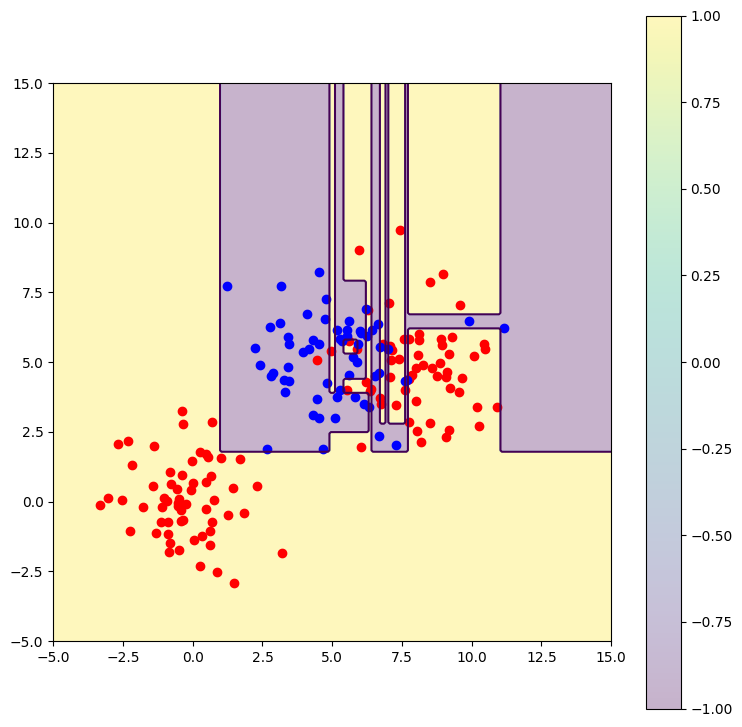

In [1]:
#Let us train an overfitted classifier. For example a DT.
%reset -f
import numpy as np
import matplotlib.pyplot as plt
MAXN=60
np.random.seed(2)
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.5*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,5]+1.5*np.random.randn(MAXN,2)])
y = np.concatenate([np.ones((MAXN,1)),-np.ones((MAXN,1))])
y = np.concatenate([y,np.ones((MAXN,1))])
idxplus = y==1
idxminus = y==-1

from sklearn import tree
from sklearn import metrics

x = np.linspace(-5,15,200)
XX,YY = np.meshgrid(x,x)
sz=XX.shape
data=np.c_[XX.ravel(),YY.ravel()]


clf = tree.DecisionTreeClassifier(criterion="entropy")
clf.fit(X,y.ravel())
Z=clf.predict(data)
mx= np.max(Z)
mn= np.min(Z)
Z.shape=sz
plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')
plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=mn, vmax=mx)
plt.colorbar()
plt.contour(XX,YY,Z,[0])

fig = plt.gcf()
fig.set_size_inches(9,9)


Process finnished.


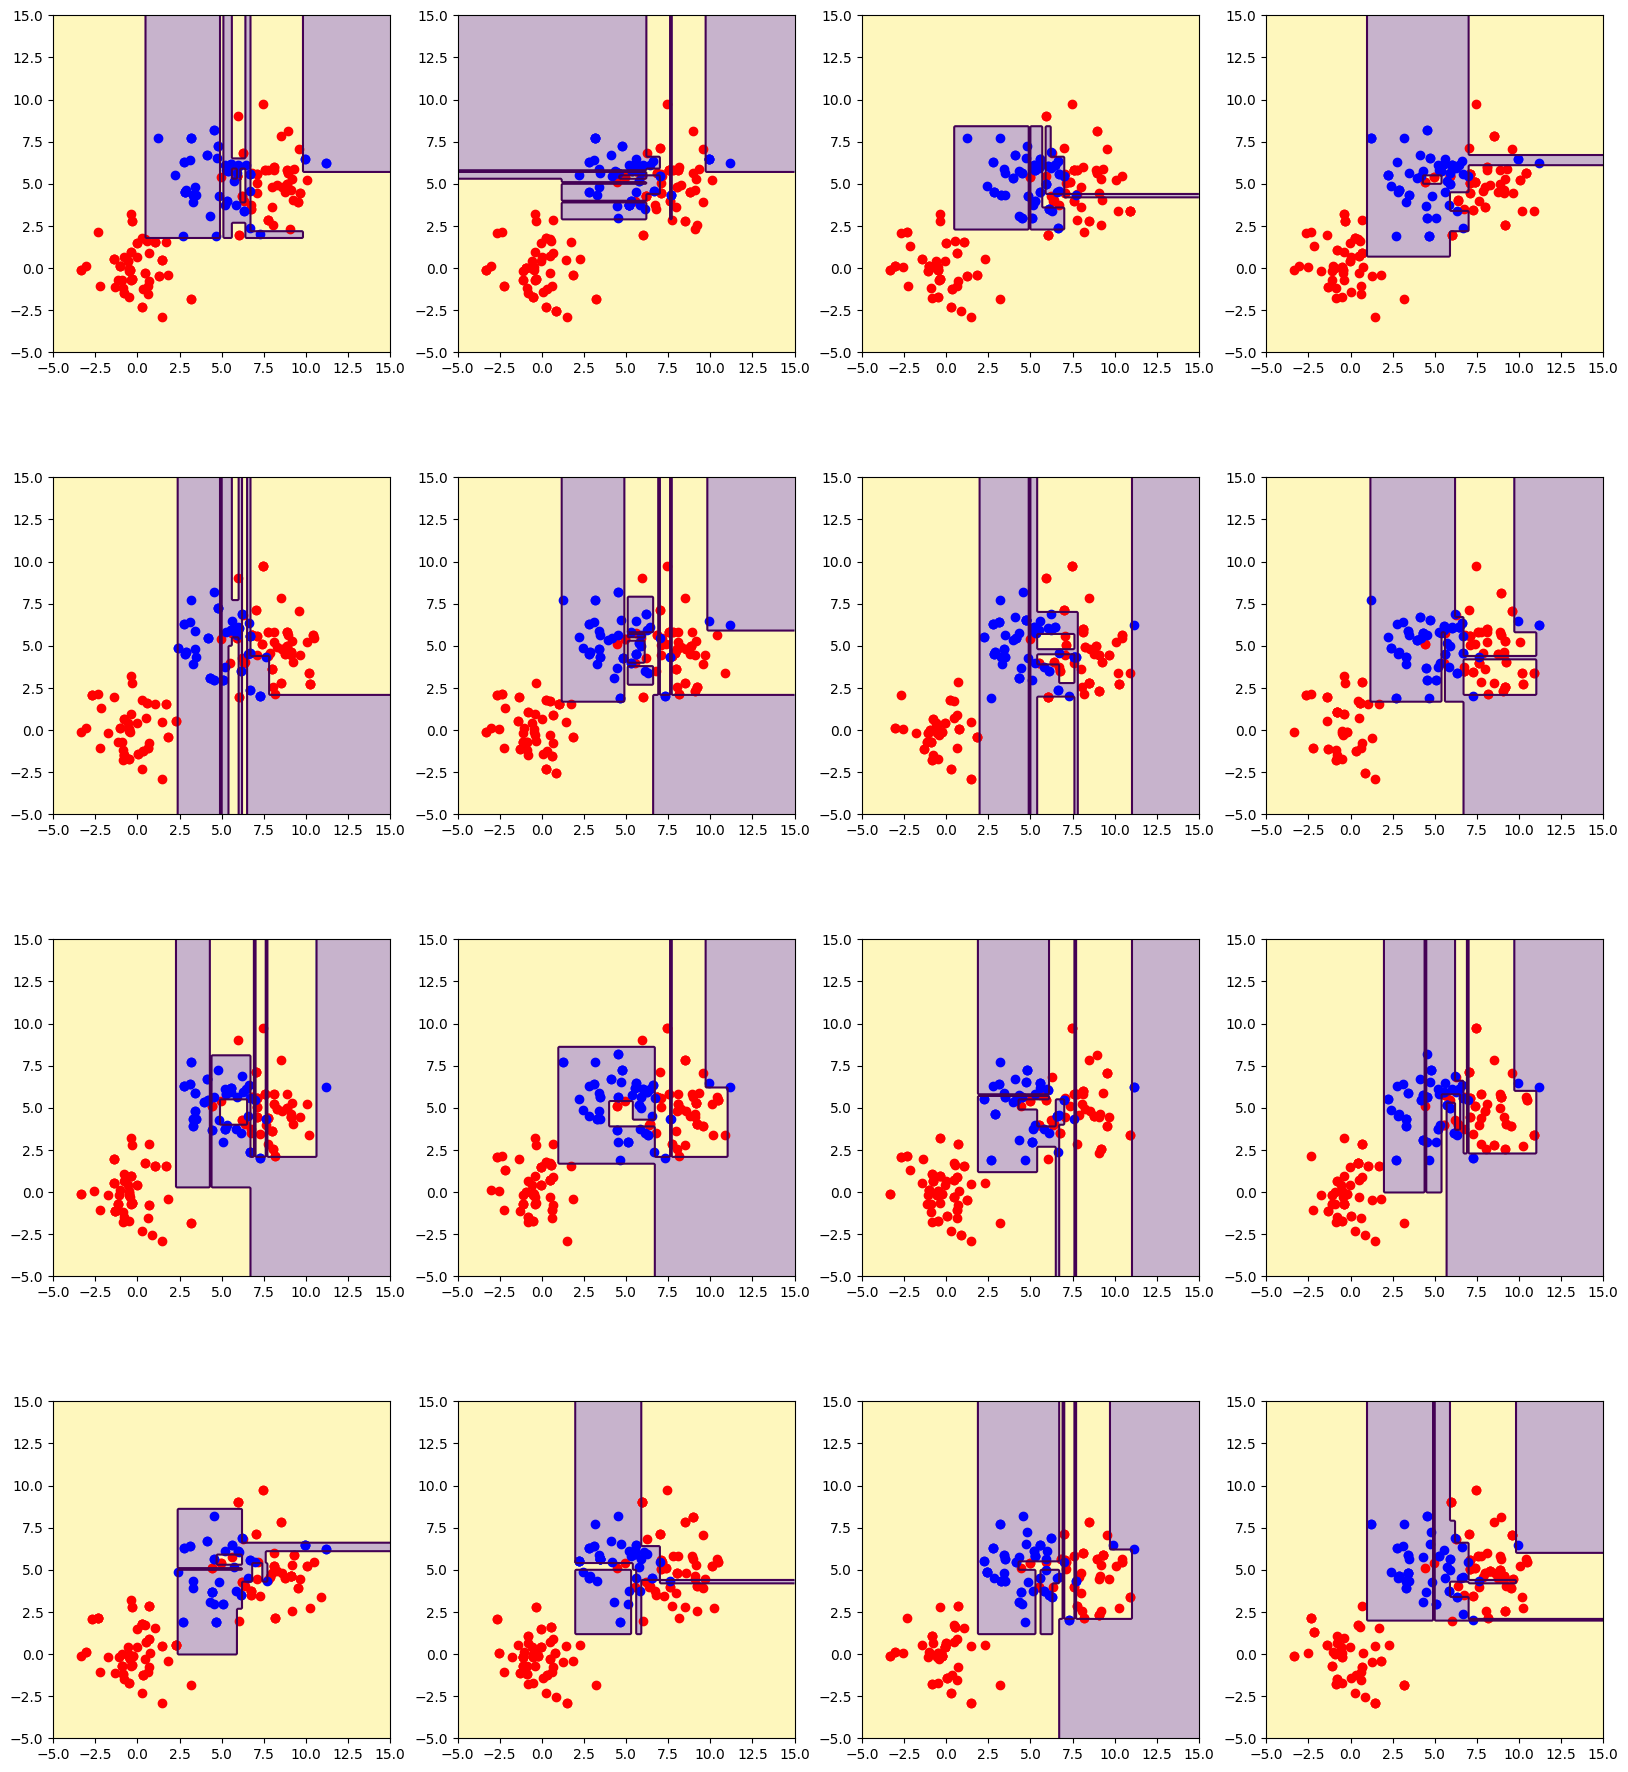

In [2]:
def train_bagged_tree(X,y,C):
    clf_list=[]
    for i in range(C):
        np.random.seed(None)
        idx=np.random.randint(0,y.shape[0],y.shape[0])
        clf = tree.DecisionTreeClassifier(criterion="entropy")
        Xr=X[idx,:]
        yr=y[idx]
        clf_list.append((clf.fit(Xr,yr.ravel()),idx))  #Add the indices for visualization purposes in test
    return clf_list


def visualize_bagged_tree(X,y,clf_list):
    C = len(clf_list)
    x = np.linspace(-5,15,200)
    XX,YY = np.meshgrid(x,x)
    sz=XX.shape
    data=np.c_[XX.ravel(),YY.ravel()]
    yhat=np.zeros((data.shape[0],len(clf_list)))
    i=0
    for dt,idx in clf_list:
        yhat[:,i]=dt.predict(data)
        Xr=X[idx,:]
        yr=y[idx]
        mx= np.max(yhat[:,i])
        mn= np.min(yhat[:,i])
        plt.subplot(int(np.floor(C/4))+1,4,i+1)
        plt.scatter(Xr[(yr==1).ravel(),0],Xr[(yr==1).ravel(),1],color='r')
        plt.scatter(Xr[(yr==-1).ravel(),0],Xr[(yr==-1).ravel(),1],color='b')
        plt.imshow(yhat[:,i].reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=mn, vmax=mx)
        plt.contour(XX,YY,yhat[:,i].reshape(sz),[0])
        i=i+1
    fig = plt.gcf()
    fig.set_size_inches(20,7*int(np.floor(C/4))+1)
    return yhat


clf_list=train_bagged_tree(X,y,16)
y_pred=visualize_bagged_tree(X,y,clf_list)
y_pred = np.sum(y_pred,axis=1)

print ('Process finnished.')


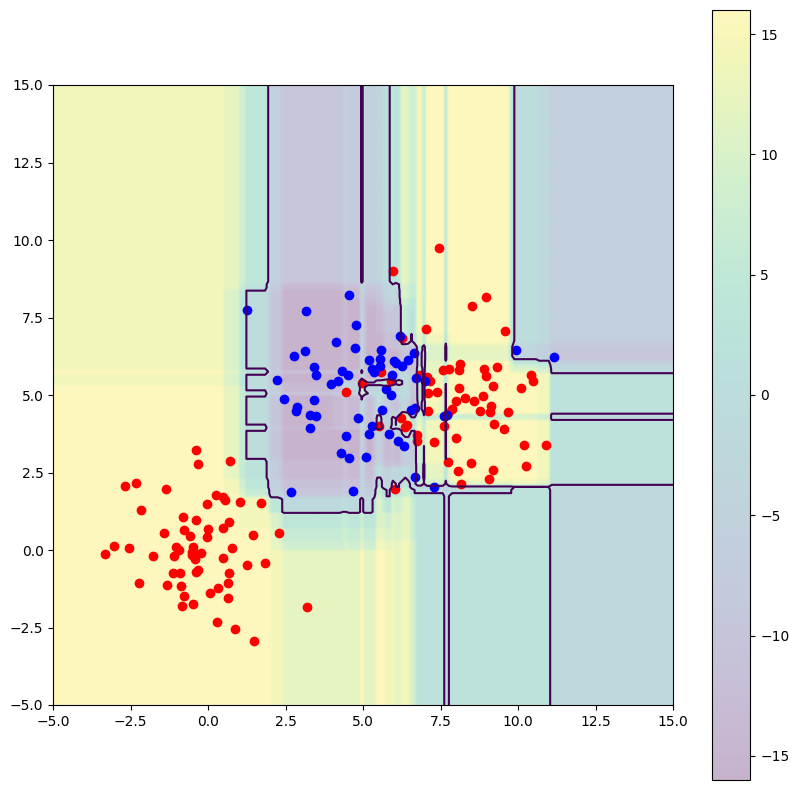

In [3]:
mx= np.max(y_pred)
mn= np.min(y_pred)
plt.figure()
plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')
plt.imshow(y_pred.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=mn, vmax=mx)
plt.colorbar()
plt.contour(XX,YY,y_pred.reshape(sz),[0])
fig = plt.gcf()
fig.set_size_inches(10,10) 

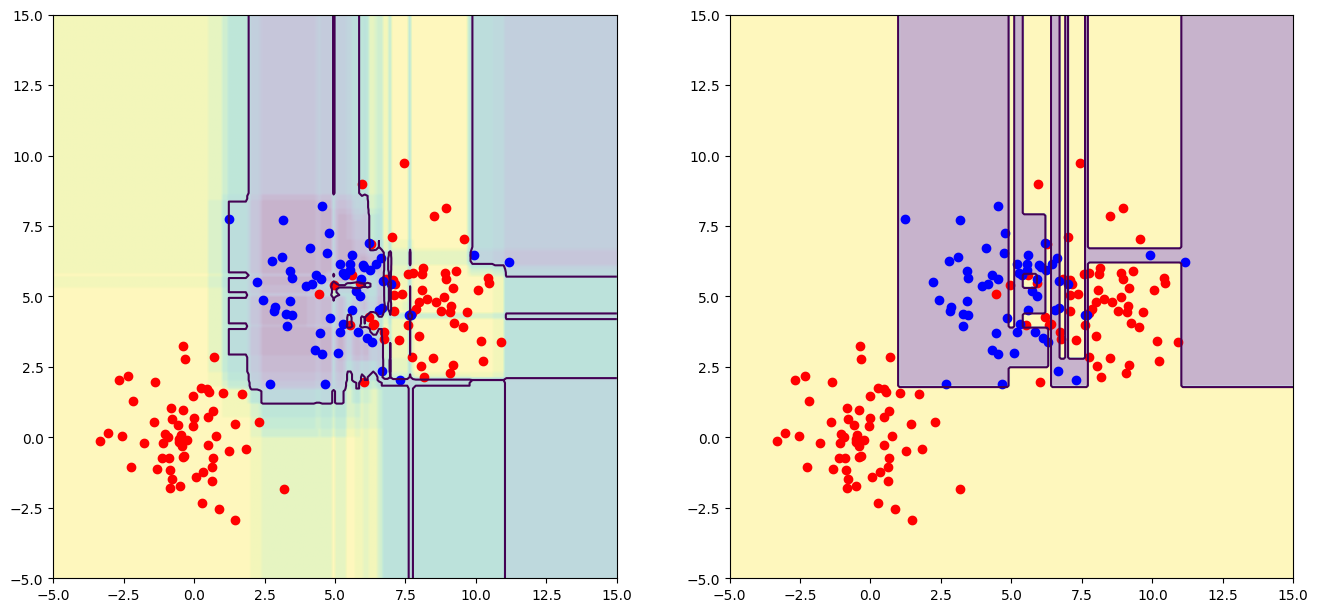

In [4]:
Zb = y_pred.reshape(sz)
plt.subplot(1,2,1)
plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')
plt.imshow(Zb, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=mn, vmax=mx)
plt.contour(XX,YY,Zb,[0])
plt.subplot(1,2,2)
plt.scatter(X[idxplus.ravel(),0],X[idxplus.ravel(),1],color='r')
plt.scatter(X[idxminus.ravel(),0],X[idxminus.ravel(),1],color='b')
plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=-1, vmax=1)
plt.contour(XX,YY,Z,[0])
fig = plt.gcf()
fig.set_size_inches(16,9)

#### Application to customer churn prediction

Let us check this approach in the Churn problem. Recall that a single decision tree achieved an accuracy of $91.7\%$, precision of $71\%$ and recall of $72\%$

In [5]:
%reset -f
#Recover Churn data
import pickle
fname = open('churn_data.pkl','rb')
data = pickle.load(fname)
X = data[0]
y = 2*data[1]-1
features = data[2]
print ('Loading ok.')

Loading ok.


In [6]:
def train_bagged_tree(X,y,C):
    clf_list=[]
    for i in range(C):
        np.random.seed(None)
        idx=np.random.randint(0,y.shape[0],y.shape[0])
        clf = tree.DecisionTreeClassifier(criterion="entropy")
        Xr=X[idx,:]
        yr=y[idx]
        clf_list.append(clf.fit(Xr,yr.ravel()))  
    return clf_list


def test_bagged_tree(X,clf_list):
    yhat=np.zeros((X.shape[0],len(clf_list)))
    i=0
    for dt in clf_list:
        yhat[:,i]=dt.predict(X)
        i=i+1
    return np.sign(np.mean(yhat,axis=1))

In [7]:
#NO SNOOPING / CORSS VALIDATION
import numpy as np
from sklearn import model_selection
from sklearn import tree
from sklearn import metrics

kf=model_selection.KFold(n_splits=5, shuffle=False)
kf.get_n_splits(X)
acc = np.zeros((5,))
i=0
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf_list = train_bagged_tree(X_train,y_train.ravel(),21)
    yhat[test_index]=test_bagged_tree(X_test,clf_list) 
    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    i=i+1
print ('Mean accuracy: '+ str(np.mean(acc)))

Mean accuracy: 0.9522945734340038


/var/folders/dk/ht9wngxs4r51l9tbk0_y94000000gp/T/ipykernel_49122/2422236388.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels, size=20)
/var/folders/dk/ht9wngxs4r51l9tbk0_y94000000gp/T/ipykernel_49122/2422236388.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels, size=20)


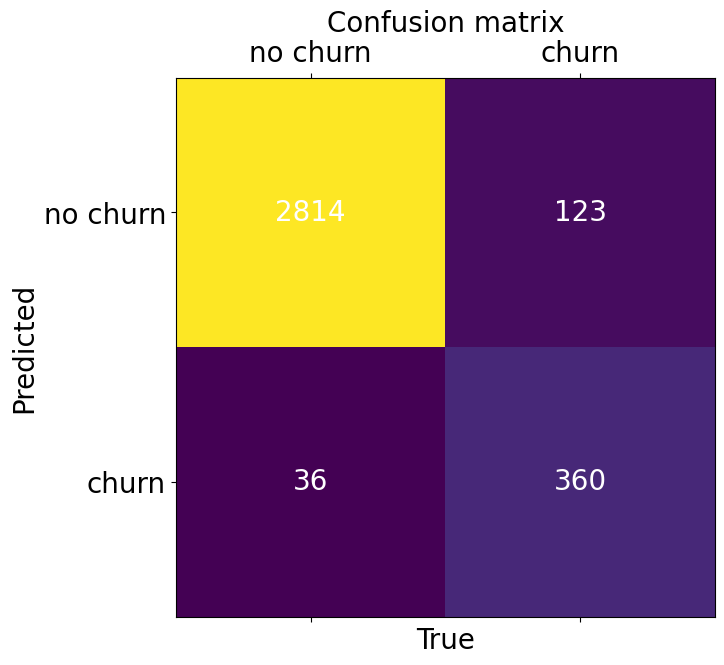

              precision    recall  f1-score   support

          -1       0.96      0.99      0.97      2850
           1       0.91      0.75      0.82       483

    accuracy                           0.95      3333
   macro avg       0.93      0.87      0.90      3333
weighted avg       0.95      0.95      0.95      3333



In [8]:
import matplotlib.pyplot as plt
def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm.T)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in range(2):
        for j in range(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(y,yhat,['no churn', 'churn'])
print (metrics.classification_report(y,yhat))

Observe that the solution accuracy increases by about $5\%$, recall goes upt to $76\%$ and precision also increases up to $93\%$.

**Bagging** performance improvement is due to the reduction of the variance of the classifier while mantaining its bias.
</div>

### Random Forest

Random Forest technique introduces a randomization over the feature selected for building  each tree in the ensemble in order to improve diversity in an attempt to reduce variance evan more. Let us code this variant of bagging.

In [9]:
%reset -f
from sklearn import tree
import numpy as np
def train_random_forest(X,y,C,F):
    F=int(np.ceil(np.sqrt(X.shape[1])))
    clf_list=[]
    for i in range(C):
        np.random.seed(None)

        ## Get a random samples of rows
        idx=np.random.randint(0,y.shape[0],y.shape[0])
        ## Get a random samples of columns
        feat_idx=np.random.permutation(np.arange(X.shape[1]))[:F]

        clf = tree.DecisionTreeClassifier(criterion="entropy")
        Xr=X[idx,:].copy()
        Xr=Xr[:,feat_idx]
        yr=y[idx]

        ## Train the classifier on a random number of feat and columns
        clf_list.append((clf.fit(Xr,yr.ravel()),feat_idx))
    return clf_list


def test_random_forest(X,clf_list):
    yhat=np.zeros((X.shape[0],len(clf_list)))
    i=0
    for dt,feat_idx in clf_list:
        yhat[:,i]=dt.predict(X[:,feat_idx])
        i=i+1
    return np.sign(np.mean(yhat,axis=1)),yhat

In [10]:
#Recover Churn data
import pickle
fname = open('churn_data.pkl','rb')
data = pickle.load(fname)
X = data[0]
y = 2*data[1]-1
print ('Labels: '+ str(np.unique(y)))
features = data[2]
print ('Loading ok.')

Labels: [-1  1]
Loading ok.


In [11]:
from sklearn import metrics
clf_list = train_random_forest(X,y,51,5)
yhat,yk = test_random_forest(X,clf_list)
acc = metrics.accuracy_score(yhat, y)
print (yk.shape)
print (np.sum(np.mean(yk,axis=1)>0))
print (acc)

(3333, 51)
482
0.9996999699969997


In [12]:
#NO SNOOPING
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn import metrics


kf=model_selection.KFold(n_splits=5, shuffle=False)
kf.get_n_splits(X)
acc = np.zeros((5,))
i=0
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = y.copy()
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ## We could use our own function...
    #clf_list = train_random_forest(X_train,y_train,51,np.ceil(np.sqrt(X.shape[1])))
    #yhat[test_index],yk = test_random_forest(X_test,clf_list)

    ## But instead lets leverage on built in ones
    dt = ensemble.RandomForestClassifier(n_estimators=51)
    dt.fit(X_train,y_train)
    yhat[test_index]=dt.predict(X_test)

    acc[i] = metrics.accuracy_score(yhat[test_index], y_test)
    i=i+1
print (acc)
print (np.unique(yhat))
print (np.unique(y_test))
print ('Mean accuracy: '+ str(np.mean(acc)))

[0.95052474 0.94752624 0.95502249 0.95645646 0.94594595]
[-1  1]
[-1  1]
Mean accuracy: 0.9510951731341537


/var/folders/dk/ht9wngxs4r51l9tbk0_y94000000gp/T/ipykernel_49122/926181432.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels, size=20)
/var/folders/dk/ht9wngxs4r51l9tbk0_y94000000gp/T/ipykernel_49122/926181432.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels, size=20)


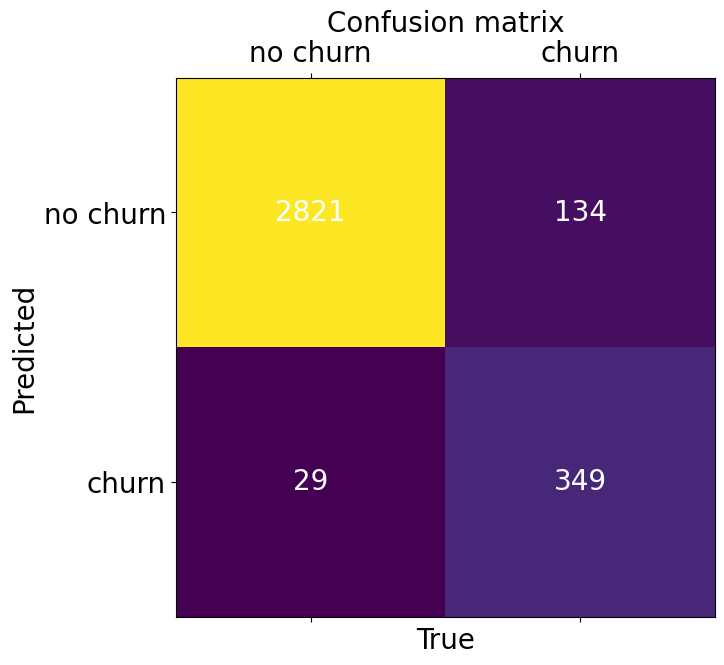

              precision    recall  f1-score   support

          -1       0.95      0.99      0.97      2850
           1       0.92      0.72      0.81       483

    accuracy                           0.95      3333
   macro avg       0.94      0.86      0.89      3333
weighted avg       0.95      0.95      0.95      3333



In [13]:
import matplotlib.pyplot as plt
def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm.T)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in range(2):
        for j in range(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()
draw_confusion(y,yhat,['no churn', 'churn'])
print (metrics.classification_report(y,yhat))

Go to slides first and finish Boosting
## 2 Introduction to the multiclass problem and Error Correcting Output Coding

### Stand Alone Reading

Up to this moment we have applied several models in multi-class problems but we have barely talked about the problem of multiple classes in learning. 

First of all, there are very few models that intrinsically handle the multi-class case. By intrinsically handling the multi-class problem I am referring to methods in which we do not have to worry about how many classes our problem has. The two big families of models that can deal with the problem are

+ Decision trees: the leaves encode the class.
+ Nearest Neighbors: we only care about class labels of instances close to my query sample.

What about the rest of the models? Did not Bayesian models or Neural Networks also handle this problem? Yes, they work in the multi-class case. But we have to worry about how many classes there are. In particular we have to build a model for each class and then take a maximum score/probability/confidence among the predictions. This way of addressing the multiclass problem is also known as **one-against-all** because we consider one model for each class while the samples from the rest of the classes are considered as negative samples. This is the first example of a reductionist framework.

The reductionist framework refers to those ensemble methods that allows to reduce the multi-class problem to a set of binary problems. In a $K$ class problem, the two most common approaches in this framework are:

+ **one-against-all:** We consider $K$ partitions of the problem, corresponding to setting one class as positive class and the rest as negative. 
+ **one-against-one:** We consider all posible pairs of classes and build a model for each subproblem. 

### Multi Class example

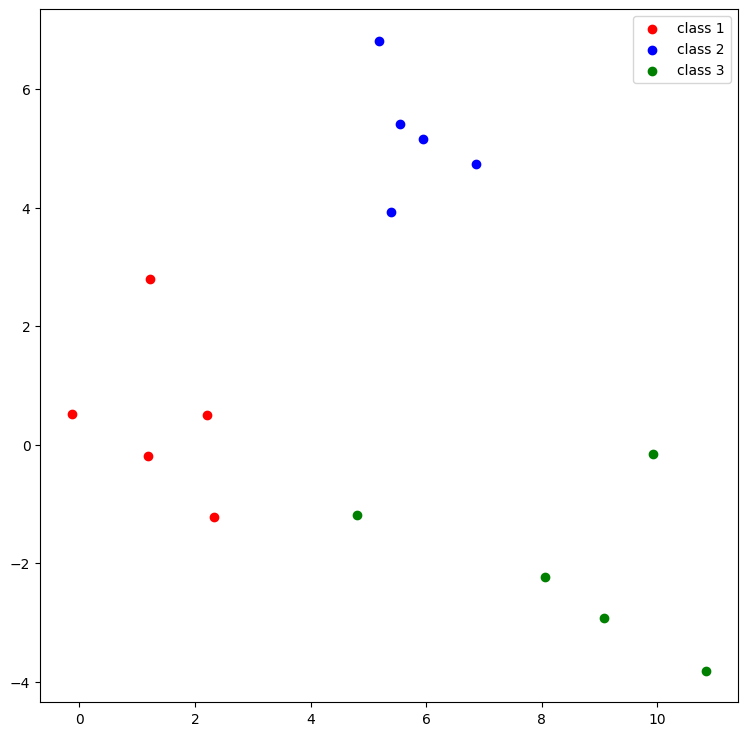

In [14]:
%reset -f
#Create a multiclass toy problem
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
MAXN=5
np.random.seed(0)
X = np.concatenate([1.25*np.random.randn(MAXN,2),5+1.25*np.random.randn(MAXN,2)]) 
X = np.concatenate([X,[8,-2]+1.25*np.random.randn(MAXN,2)])
y = np.concatenate([np.ones((MAXN,1)),2*np.ones((MAXN,1))])
y = np.concatenate([y,3*np.ones((MAXN,1))])

#Display data
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r',label='class 1')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b',label='class 2')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g',label='class 3')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(9,9)

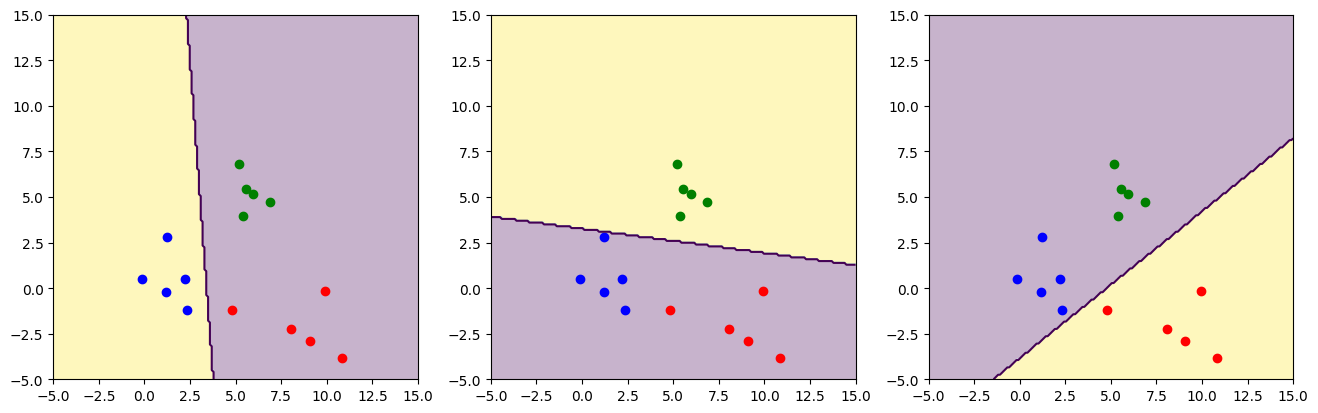

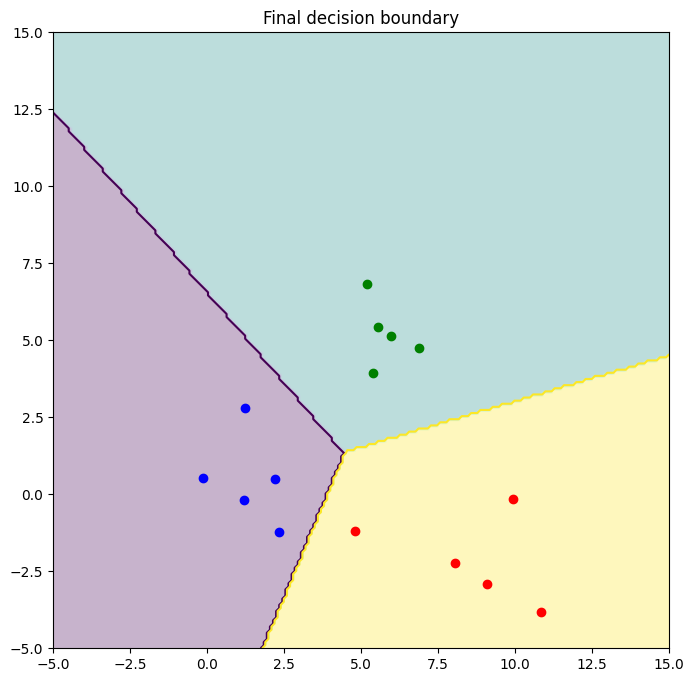

In [15]:
#Train a LinearSVC in one-vs-all fashion
clf_list=[]
for i in range(3):
    clf = svm.LinearSVC()
    y_meta = y.copy()
    #Create a binary problem with one class at +1 and the rest at -1
    y_meta=np.where(y_meta == i+1 ,1,-1)
    clf_list.append(clf.fit(X,y_meta.ravel()))

#Test each classifier
plt.figure()
x = np.linspace(-5,15,200)
XX,YY = np.meshgrid(x,x)
sz=XX.shape
data=np.c_[XX.ravel(),YY.ravel()]
i=1
yhat_d=np.empty((data.shape[0],3))
for c in clf_list:
    yhat=c.predict(data)
    #Visualization of each boundary
    yhat_d[:,i-1]=c.decision_function(data)
    mn = np.min(yhat)
    mx = np.max(yhat)
    plt.subplot(1,3,i)
    plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='b',label='class 1')
    plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='g',label='class 2')
    plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='r',label='class 3')
    plt.imshow(yhat.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=mn, vmax=mx)
    plt.contour(XX,YY,yhat.reshape(sz),[0])
    i=i+1
fig = plt.gcf()
fig.set_size_inches(16,9)

y_final=np.argmax(yhat_d,axis=1)
plt.figure()
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='b',label='class 1')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='g',label='class 2')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='r',label='class 3')
plt.imshow(y_final.reshape(sz), interpolation='bilinear', origin='lower', extent=(-5,15,-5,15),alpha=0.3, vmin=0, vmax=2)
plt.contour(XX,YY,y_final.reshape(sz),[0, 1])
plt.title("Final decision boundary")
fig = plt.gcf()
fig.set_size_inches(16,8)